# Прогнозирование оттока клиентов в сети отелей «Как в гостях» <a id="intro"></a>

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание" data-toc-modified-id="Описание-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание</a></span></li><li><span><a href="#Загрузка-и-подготовка-данных" data-toc-modified-id="Загрузка-и-подготовка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Загрузка и подготовка данных</a></span></li><li><span><a href="#Предобработка-и-исследовательский-анализ-данных" data-toc-modified-id="Предобработка-и-исследовательский-анализ-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Предобработка и исследовательский анализ данных</a></span></li><li><span><a href="#Формулировка-ML-задачи-на-основе-бизнес-задачи" data-toc-modified-id="Формулировка-ML-задачи-на-основе-бизнес-задачи-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Формулировка ML-задачи на основе бизнес-задачи</a></span></li><li><span><a href="#Разработка-модели-ML" data-toc-modified-id="Разработка-модели-ML-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Разработка модели ML</a></span></li><li><span><a href="#Портрет-«ненадёжного»-клиента" data-toc-modified-id="Портрет-«ненадёжного»-клиента-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Портрет «ненадёжного» клиента</a></span></li><li><span><a href="#Общие-выводы" data-toc-modified-id="Общие-выводы-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Общие выводы</a></span></li></ul></div>

## Описание

Заказчик исследования — сеть отелей «Как в гостях».

Чтобы привлечь клиентов, сеть отелей добавила на свой сайт возможность забронировать номер без предоплаты. Однако если клиент отменял бронирование, то компания терпела убытки. Сотрудники отеля могли, например, закупить продукты к приезду гостя или просто не успеть найти другого клиента.

Для решения проблемы требуется разработать систему, которая предсказывает отказ от брони. Если модель покажет, что бронь будет отменена, то клиенту предлагается внести депозит. Размер депозита — 80% от стоимости номера за одни сутки и затрат на разовую уборку. Деньги будут списаны со счёта клиента, если он всё же отменит бронь.

**Бизнес-метрика и входная информация**

Основная бизнес-метрика отели — прибыль. Прибыль отеля — это разница между стоимостью номера за все ночи и затраты на обслуживание: как при подготовке номера, так и при проживании постояльца.

В отеле есть несколько типов номеров. В зависимости от типа номера назначается стоимость за одну ночь. Есть также затраты на уборку. Если клиент снял номер надолго, то убираются каждые два дня.

Стоимость номеров отеля:\
категория A: за ночь — 1 000, разовое обслуживание — 400;\
категория B: за ночь — 800, разовое обслуживание — 350;\
категория C: за ночь — 600, разовое обслуживание — 350;\
категория D: за ночь — 550, разовое обслуживание — 150;\
категория E: за ночь — 500, разовое обслуживание — 150;\
категория F: за ночь — 450, разовое обслуживание — 150;\
категория G: за ночь — 350, разовое обслуживание — 150.

В ценовой политике отеля используются сезонные коэффициенты: весной и осенью цены повышаются на 20%, летом — на 40%.

Убытки отеля в случае отмены брони номера — это стоимость одной уборки и одной ночи с учётом сезонного коэффициента.

На разработку системы прогнозирования заложен бюджет — 400 000. При этом необходимо учесть, что внедрение модели должно окупиться за тестовый период. Затраты на разработку должны быть меньше той выручки, которую система принесёт компании.

## Загрузка и подготовка данных

Импортируем необходимые библиотеки.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

Загрузим входные данные.

In [2]:
train = pd.read_csv("hotel_train.csv")
test = pd.read_csv("hotel_test.csv")

Для удобства создадим объект `list` из датафреймов.

In [3]:
data_list = [train,test]

Как выглядят датафреймы? Посмотрим.

In [4]:
for data in data_list:
    display(data.head(3))

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,0,7.0,2015,July,27,1,0,1,1.0,0.0,0.0,BB,GBR,Direct,0,0,0,A,0,0,Transient,0,0,1
1,1,0,14.0,2015,July,27,1,0,2,2.0,0.0,0.0,BB,GBR,TA/TO,0,0,0,A,0,0,Transient,0,1,2
2,2,0,0.0,2015,July,27,1,0,2,2.0,0.0,0.0,BB,PRT,Direct,0,0,0,C,0,0,Transient,0,0,2


,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,6086,1,74.0,2017,January,1,1,1,0,2.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,0,1
1,6087,1,62.0,2017,January,1,1,2,2,2.0,0.0,0.0,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
2,6088,1,62.0,2017,January,1,1,2,2,2.0,0.0,0.0,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4


Посмотрим типы данных.

In [5]:
for data in data_list:
    print(data.info())
    print("*"*60)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65229 non-null  int64  
 1   is_canceled                     65229 non-null  int64  
 2   lead_time                       65229 non-null  float64
 3   arrival_date_year               65229 non-null  int64  
 4   arrival_date_month              65229 non-null  object 
 5   arrival_date_week_number        65229 non-null  int64  
 6   arrival_date_day_of_month       65229 non-null  int64  
 7   stays_in_weekend_nights         65229 non-null  int64  
 8   stays_in_week_nights            65229 non-null  int64  
 9   adults                          65229 non-null  float64
 10  children                        65229 non-null  float64
 11  babies                          65229 non-null  float64
 12  meal                            

[В начало](#intro)

## Предобработка и исследовательский анализ данных

Перейдем к предобработке данных, проверим наличие явных дубликатов.

In [6]:
for data in data_list:
    display(data[data.duplicated()])

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights


,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights


Удалим ненужные столбцы `id`, `arrival_date_year`. Столбец `arrival_date_year` не нужен для нашей модели, также не помогает в выявлении признаков «ненадёжного» клиента.

Проверим еще раз наличие дубликатов.

In [7]:
for data in data_list:
    data.drop(["id", "arrival_date_year"], axis=1, inplace=True)
    print(data.duplicated().sum())

21387
7717


Обнаружены дубликаты в большом количестве как в обучающем, так и тестовом наборе данных. Можем ли мы удалить эти дубликаты? Потенциально да, однако, невозможно установить причину и определить эти данные как дубликаты, поскольку, это могут быть туристы с одинаковыми параметрами, удалив данные мы не рассчитаем действительную прибыль отеля, поэтому пока оставляем.

Поохотимся на неявные дубликаты.

In [8]:
print(train["arrival_date_month"].unique())
print(test["arrival_date_month"].unique())

['July' 'August' 'September' 'October' 'November' 'December' 'January'
 'February' 'March' 'April' 'May' 'June']
['January' 'February' 'March' 'April' 'May' 'June' 'July' 'August']


Тут все в порядке. Стоит упомянуть, что тестовый набор не представлен всеми месяцами в году, учтем это при построении логистической регресии, где не подходит порядкое кодирование.

In [9]:
print(train["meal"].unique())
print(test["meal"].unique())

['BB       ' 'FB       ' 'HB       ' 'SC       ' 'SC']
['BB       ' 'HB       ' 'SC' 'FB       ' 'SC       ']


Удалим пробелы для унификации.

In [10]:
train["meal"] =  train["meal"].str.strip()
test["meal"] = test["meal"].str.strip()
print(train["meal"].unique())
print(test["meal"].unique())

['BB' 'FB' 'HB' 'SC']
['BB' 'HB' 'SC' 'FB']


In [11]:
print(train["country"].unique())
print(test["country"].unique())

['GBR' 'PRT' 'ESP' 'IRL' 'FRA' 'ROU' 'NOR' 'USA' 'DEU' 'BEL' 'CHE' 'CN'
 'GRC' 'NLD' 'ARG' 'RUS' 'SWE' 'POL' 'EST' 'CZE' 'ITA' 'FIN' 'DNK' 'MOZ'
 'BWA' 'LUX' 'BRA' 'SVN' 'ALB' 'CHN' 'MEX' 'MAR' 'SMR' 'LVA' 'CHL' 'AUT'
 'LTU' 'TUR' 'ISR' 'IND' 'CYM' 'AUS' 'CPV' 'ZWE' 'DZA' 'KOR' 'CRI' 'HUN'
 'TUN' 'ARE' 'HRV' 'HKG' 'IRN' 'GIB' 'JEY' 'URY' 'ZAF' 'COL' 'GGY' 'KWT'
 'CYP' 'KAZ' 'THA' 'DOM' 'NGA' 'BLR' 'VEN' 'UKR' 'ARM' 'JPN' 'LKA' 'MYS'
 'BIH' 'MUS' 'OMN' 'SUR' 'JAM' 'BGR' 'CIV' 'SRB' 'JOR' 'SYR' 'PHL' 'PRI'
 'SGP' 'BDI' 'LBN' 'AGO' 'VNM' 'AZE' 'PLW' 'NZL' 'EGY' 'MDV' 'CMR' 'MLT'
 'SVK' 'MWI' 'STP' 'TWN' 'IDN' 'SEN' 'PER' 'SAU' 'KNA' 'ETH' 'ECU' 'IRQ'
 'AND' 'HND' 'PAK' 'GEO' 'ZMB' 'QAT' 'KHM' 'MCO' 'BGD' 'ISL' 'UZB' 'IMN'
 'TJK' 'NIC' 'BEN' 'MAC' 'VGB' 'TZA' 'GAB' 'MKD' 'TMP' 'GLP' 'KEN' 'LIE'
 'MMR' 'PAN' 'BFA' 'LBY' 'GNB' 'MLI' 'BHR' 'NAM' 'BOL' 'SYC' 'PRY' 'BRB'
 'ABW' 'SLV' 'DMA' 'CUB' 'PYF' 'UGA' 'GUY' 'LCA' 'ATA' 'RWA' 'MNE']
['PRT' 'AUT' 'BEL' 'DEU' 'BRA' 'GBR' 'ESP' 'FRA' 'ITA' 'L

In [12]:
print(train["distribution_channel"].unique())
print(test["distribution_channel"].unique())

['Direct' 'TA/TO' 'Corporate' 'GDS']
['TA/TO' 'Direct' 'Corporate' 'GDS']


In [13]:
print(train["reserved_room_type"].unique())
print(test["reserved_room_type"].unique())

['A               ' 'C               ' 'D               '
 'E               ' 'G               ' 'F               '
 'B               ']
['A               ' 'E               ' 'G               '
 'D               ' 'F               ' 'C               '
 'B               ']


Аналогично, удалим пробелы для унификации.

In [14]:
train["reserved_room_type"] = train["reserved_room_type"].str.strip()
test["reserved_room_type"] = test["reserved_room_type"].str.strip()
print(train["reserved_room_type"].unique())
print(test["reserved_room_type"].unique())

['A' 'C' 'D' 'E' 'G' 'F' 'B']
['A' 'E' 'G' 'D' 'F' 'C' 'B']


In [15]:
print(train["customer_type"].unique())
print(test["customer_type"].unique())

['Transient' 'Contract' 'Transient-Party' 'Group']
['Transient' 'Transient-Party' 'Contract' 'Group']


Посмотрим методом describe на объекты типа "object".

In [16]:
concat = pd.concat([train]+[test])

In [17]:
display(concat.describe(include="object").T) # Посмотрим общее распределение
for data in data_list:
    display(data.describe(include="object").T) # посмотрим распределение данных в обучающей и тестовой выборке по-отдельности

,count,unique,top,freq
arrival_date_month,97641,12,May,9939
meal,97641,4,BB,76381
country,97641,174,PRT,38718
distribution_channel,97641,4,TA/TO,81537
reserved_room_type,97641,7,A,73972
customer_type,97641,4,Transient,72954


,count,unique,top,freq
arrival_date_month,65229,12,October,9255
meal,65229,4,BB,51697
country,65229,155,PRT,28831
distribution_channel,65229,4,TA/TO,54454
reserved_room_type,65229,7,A,50501
customer_type,65229,4,Transient,45493


,count,unique,top,freq
arrival_date_month,32412,8,May,5262
meal,32412,4,BB,24684
country,32412,143,PRT,9887
distribution_channel,32412,4,TA/TO,27083
reserved_room_type,32412,7,A,23471
customer_type,32412,4,Transient,27461


Судя по данным аномалии или артефакты отсутствуют, какие еще можем сделать выводы:
- наиболее популярный месяц для бронивания - май;
- чаще всего клиенты прибывают в отель из Португалии;
- больше всего клиенты предпочитают тип питания - только завтраки и самые дорогие номера;
- самый популярный тип клиента Transient - индивидуальный заезд.

Посмотрим статистическое описание количественных данных.

In [18]:
display(concat.describe().T)
for data in data_list:
    display(data.describe().T)

,count,mean,std,min,25%,50%,75%,max
is_canceled,97641.0,0.375201,0.484177,0.0,0.0,0.0,1.0,1.0
lead_time,97641.0,96.752839,93.045823,0.0,19.0,68.0,152.0,374.0
arrival_date_week_number,97641.0,26.846581,13.772847,1.0,16.0,27.0,38.0,53.0
arrival_date_day_of_month,97641.0,15.784455,8.754660,1.0,8.0,16.0,23.0,31.0
stays_in_weekend_nights,97641.0,0.839361,0.853682,0.0,0.0,1.0,2.0,4.0
stays_in_week_nights,97641.0,2.263066,1.362798,0.0,1.0,2.0,3.0,6.0
adults,97641.0,1.843887,0.483393,0.0,2.0,2.0,2.0,4.0
children,97641.0,0.077836,0.337358,0.0,0.0,0.0,0.0,3.0
babies,97641.0,0.006667,0.091790,0.0,0.0,0.0,0.0,10.0
is_repeated_guest,97641.0,0.028554,0.166549,0.0,0.0,0.0,0.0,1.0


,count,mean,std,min,25%,50%,75%,max
is_canceled,65229.0,0.368609,0.482431,0.0,0.0,0.0,1.0,1.0
lead_time,65229.0,96.337917,96.127545,0.0,17.0,64.0,151.0,374.0
arrival_date_week_number,65229.0,31.339772,13.464024,1.0,21.0,34.0,42.0,53.0
arrival_date_day_of_month,65229.0,15.847813,8.748182,1.0,8.0,16.0,23.0,31.0
stays_in_weekend_nights,65229.0,0.825185,0.853477,0.0,0.0,1.0,2.0,4.0
stays_in_week_nights,65229.0,2.224793,1.354992,0.0,1.0,2.0,3.0,6.0
adults,65229.0,1.836576,0.480245,0.0,2.0,2.0,2.0,4.0
children,65229.0,0.074890,0.334243,0.0,0.0,0.0,0.0,3.0
babies,65229.0,0.007236,0.098790,0.0,0.0,0.0,0.0,10.0
is_repeated_guest,65229.0,0.027151,0.162523,0.0,0.0,0.0,0.0,1.0


,count,mean,std,min,25%,50%,75%,max
is_canceled,32412.0,0.388467,0.487409,0.0,0.0,0.0,1.0,1.0
lead_time,32412.0,97.587869,86.507146,0.0,23.0,76.0,155.0,373.0
arrival_date_week_number,32412.0,17.804054,9.177384,1.0,10.0,18.0,25.0,35.0
arrival_date_day_of_month,32412.0,15.656948,8.766429,1.0,8.0,15.5,23.0,31.0
stays_in_weekend_nights,32412.0,0.867888,0.853394,0.0,0.0,1.0,2.0,4.0
stays_in_week_nights,32412.0,2.340090,1.375170,0.0,1.0,2.0,3.0,6.0
adults,32412.0,1.858602,0.489341,0.0,2.0,2.0,2.0,4.0
children,32412.0,0.083765,0.343470,0.0,0.0,0.0,0.0,3.0
babies,32412.0,0.005523,0.075757,0.0,0.0,0.0,0.0,2.0
is_repeated_guest,32412.0,0.031377,0.174338,0.0,0.0,0.0,0.0,1.0


Можно сделать следующие выводы:
- наблюдается дисбаланс классов, как по общим, так и в отдельности по датафреймам;
- наблюдаются выбросы в данных в столбце lead_time (количество дней между датой бронирования и датой прибытия);
- в столбце adults (количество взрослых постояльцев) минимальное значение 0, скорее всего ошибка в данных;
- в столбце babies (количество младенцев) максимальное значение 10, необходимо поверить на корректность данных;
- в столбце required_car_parking_space максимальное значение 8, также необходимо поверить на корректность данных.

Учтем указанные выше моменты в дальнейшем.

Столбец total_nights отражает общее количество проведенных ночей, еще этот столбец разбивается на два столбца stays_in_weekend_nights и stays_in_week_nights, общая сумма эти двух столбцов должна биться со столбцом total_nights, проверим.

In [19]:
display(train[(train["stays_in_weekend_nights"] + train["stays_in_week_nights"]) != train["total_nights"]])
display(test[(test["stays_in_weekend_nights"] + test["stays_in_week_nights"]) != test["total_nights"]])

,is_canceled,lead_time,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights


,is_canceled,lead_time,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights


Все корректно, идем дальше. Проверим записи на наличие в них нулей для информации о количестве взрослых постояльцев.

In [20]:
print(train[train["adults"]==0].shape[0])
print(test[test["adults"]==0].shape[0])

166
69


Таких записей не мало, без взрослых постояльцев номера не бронируются, удалим эти записи.

In [21]:
train.drop(train[train["adults"]==0].index, inplace=True)
test.drop(test[test["adults"]==0].index, inplace=True)

In [22]:
print(train[train["adults"]==0].shape[0])
print(test[test["adults"]==0].shape[0])

0
0


In [23]:
print(train["children"].value_counts())
print(test["children"].value_counts())

children
0.0    61697
1.0     2163
2.0     1195
3.0        8
Name: count, dtype: int64
children
0.0    30353
1.0     1392
2.0      595
3.0        3
Name: count, dtype: int64


В большинстве своем посетители без детей в возрасте от 3 до 14 лет, данные корректные, менять ничего не будем.

In [24]:
print(train["babies"].value_counts())
print(test["babies"].value_counts())

babies
0.0     64614
1.0       444
2.0         3
10.0        1
9.0         1
Name: count, dtype: int64
babies
0.0    32168
1.0      171
2.0        4
Name: count, dtype: int64


Сложно представить посетителей с 10 младенцами, в основном все без младенцев, сделаем этот столбец бинарным. 

In [25]:
train.loc[train["babies"] > 1, "babies"] = 1
test.loc[test["babies"] > 1, "babies"] = 1
print(train["babies"].value_counts())
print(test["babies"].value_counts())

babies
0.0    64614
1.0      449
Name: count, dtype: int64
babies
0.0    32168
1.0      175
Name: count, dtype: int64


In [26]:
print(train["required_car_parking_spaces"].value_counts())
print(test["required_car_parking_spaces"].value_counts())

required_car_parking_spaces
0    61383
1     3668
2       11
3        1
Name: count, dtype: int64
required_car_parking_spaces
0    30868
1     1466
2        6
8        2
3        1
Name: count, dtype: int64


Аналогично, сделаем этот столбец тоже бинарным. 

In [27]:
train.loc[train["required_car_parking_spaces"] > 1, "required_car_parking_spaces"] = 1
test.loc[test["required_car_parking_spaces"] > 1, "required_car_parking_spaces"] = 1
print(train["required_car_parking_spaces"].value_counts())
print(test["required_car_parking_spaces"].value_counts())

required_car_parking_spaces
0    61383
1     3680
Name: count, dtype: int64
required_car_parking_spaces
0    30868
1     1475
Name: count, dtype: int64


Обновим индексы.

In [28]:
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

Посмотрим на распределение количественных данных на графиках.

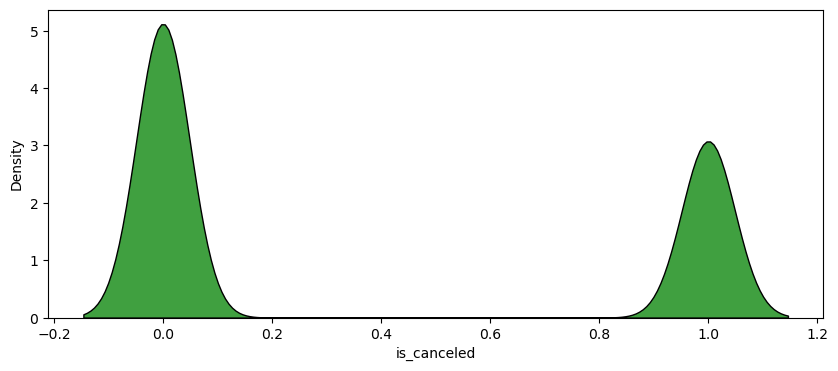

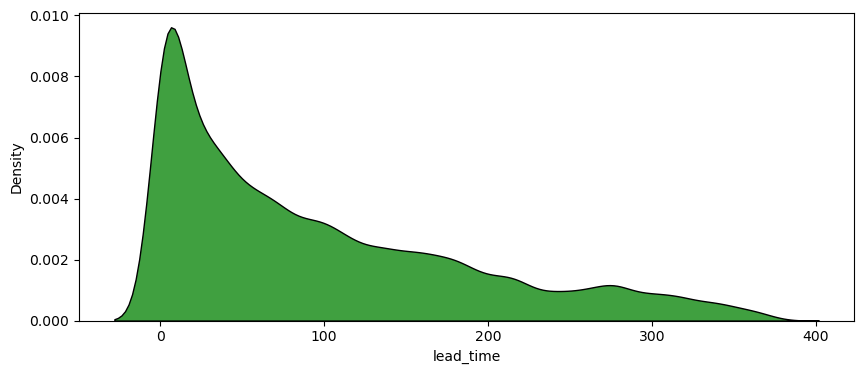

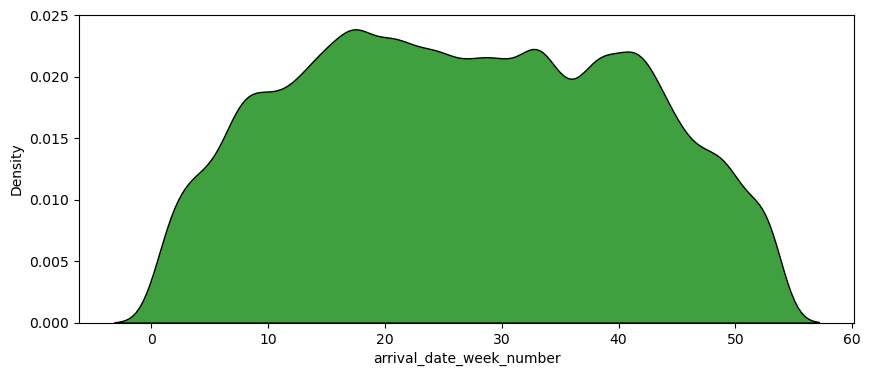

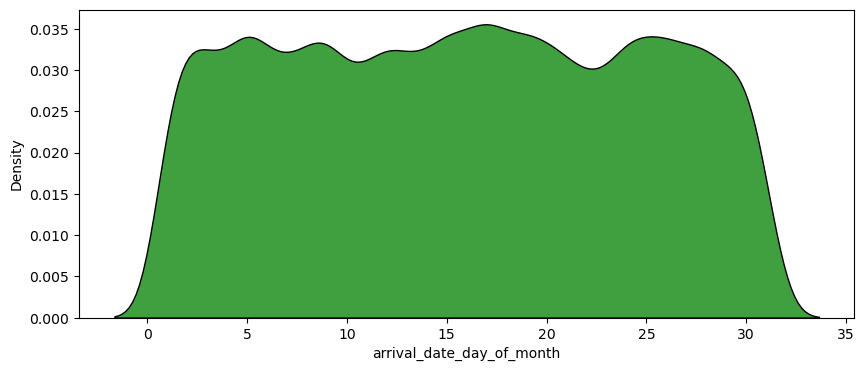

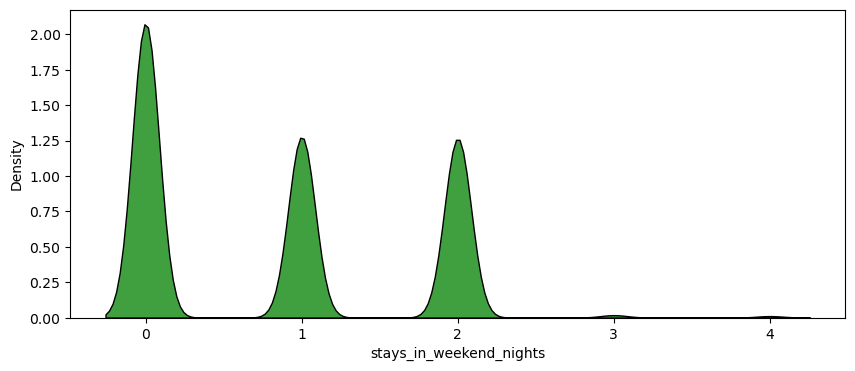

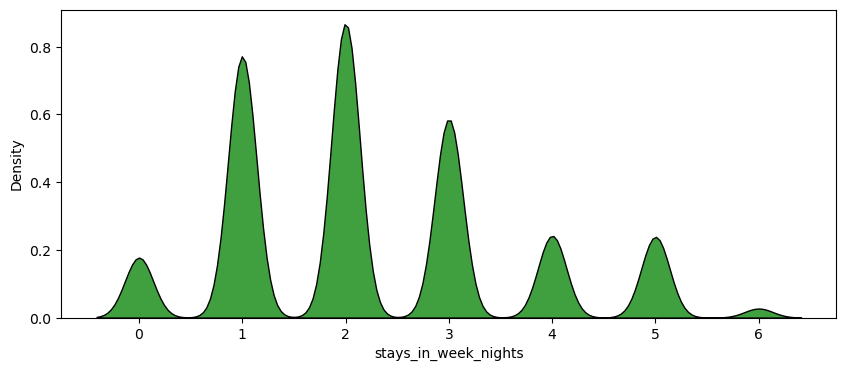

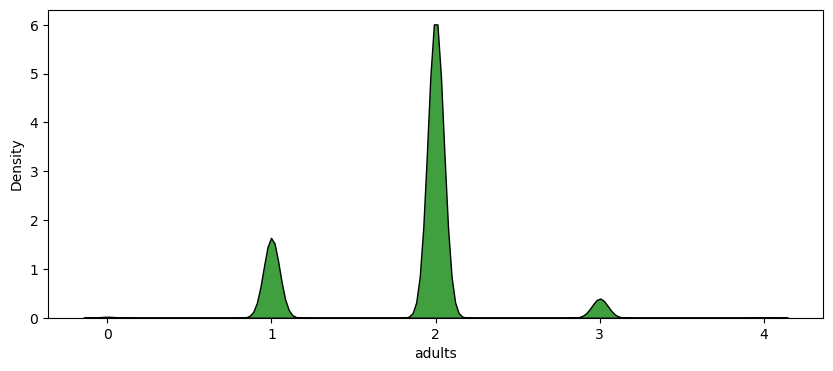

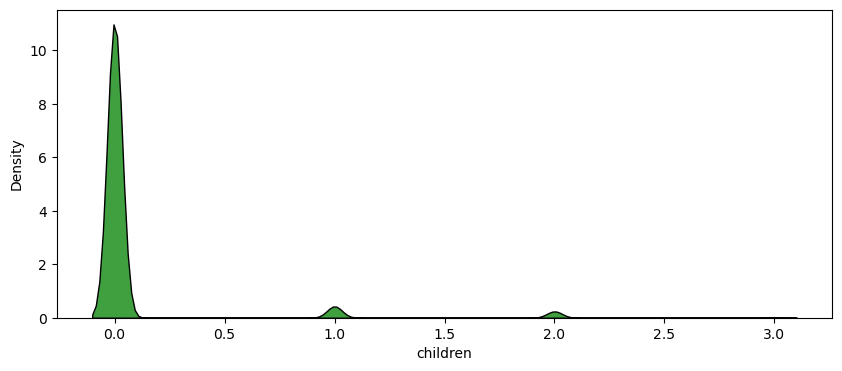

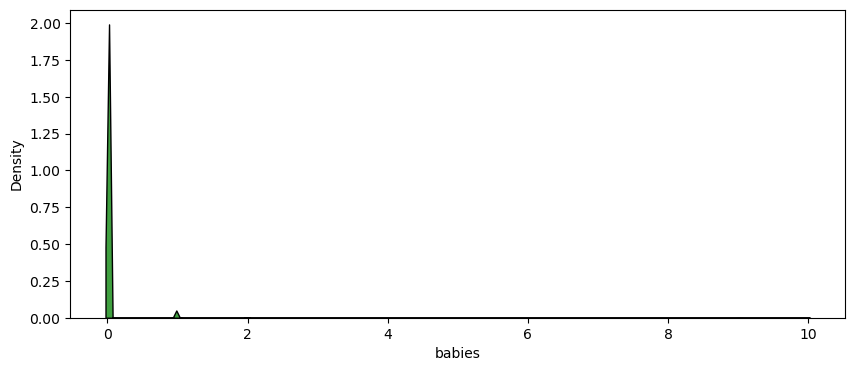

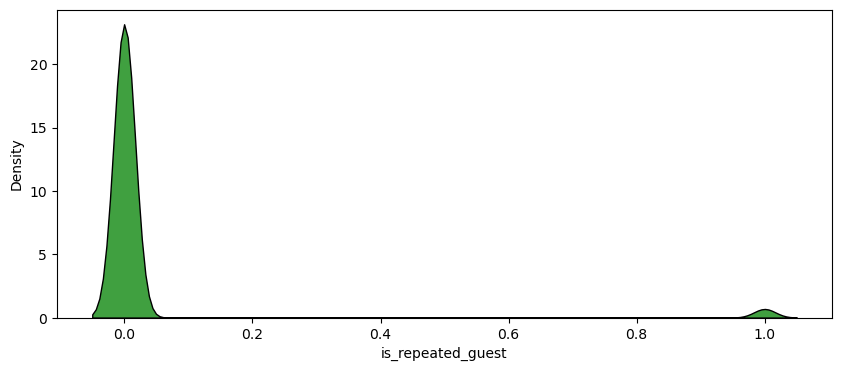

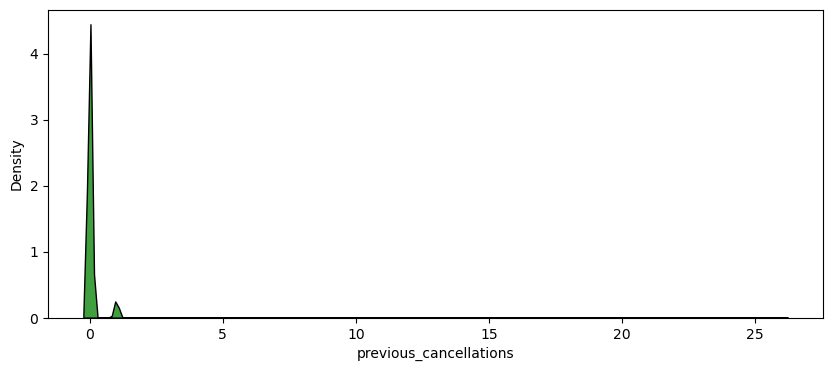

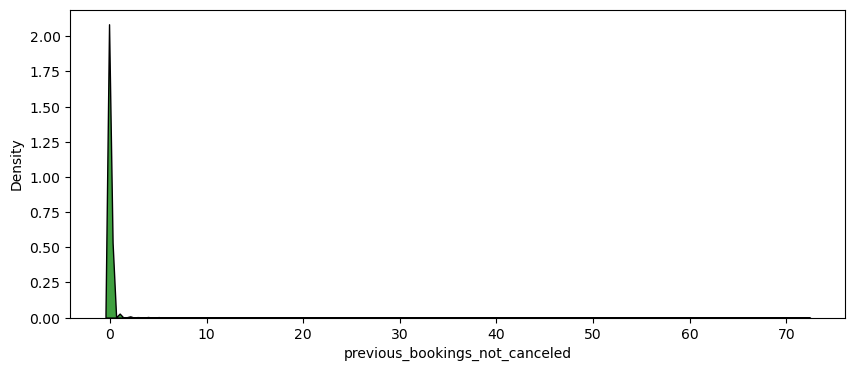

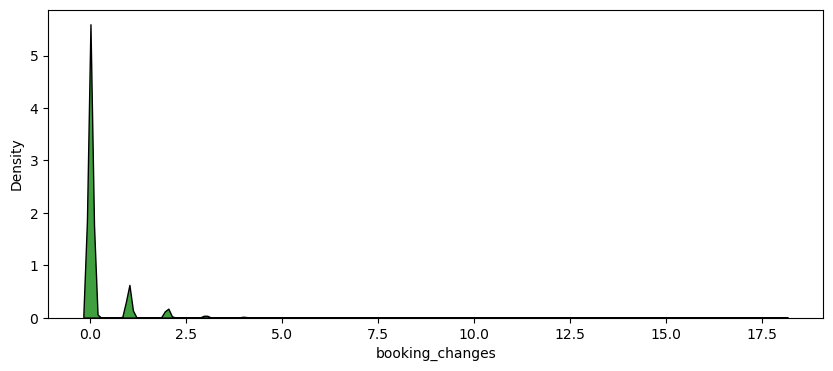

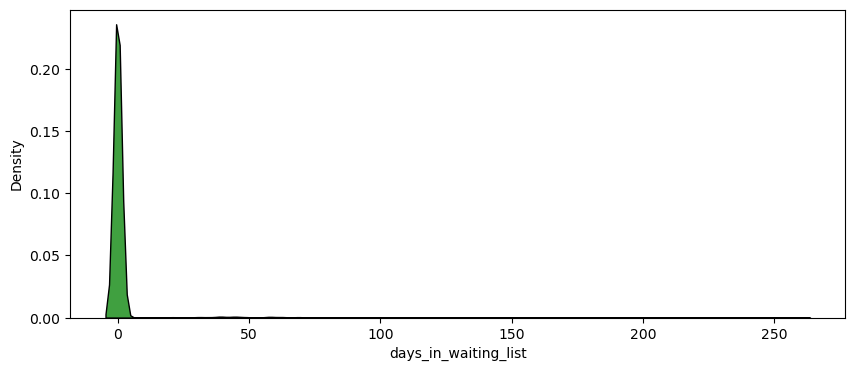

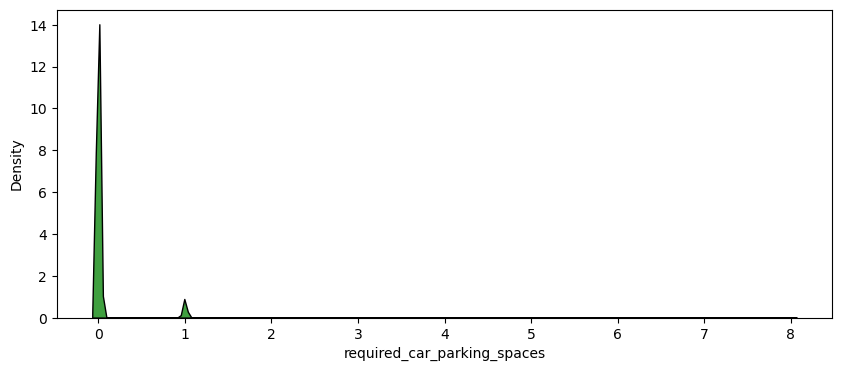

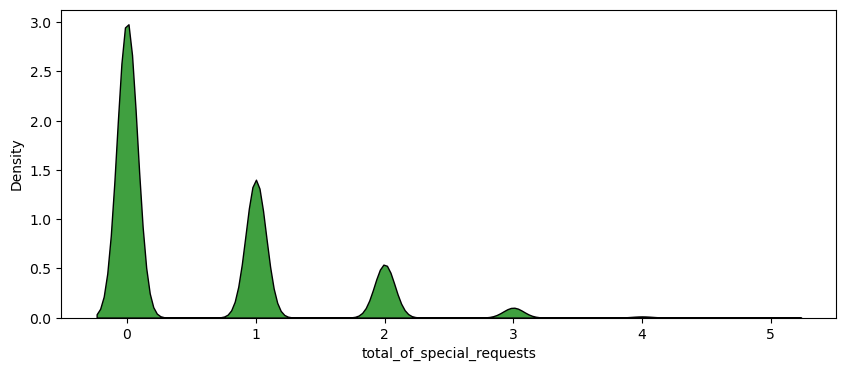

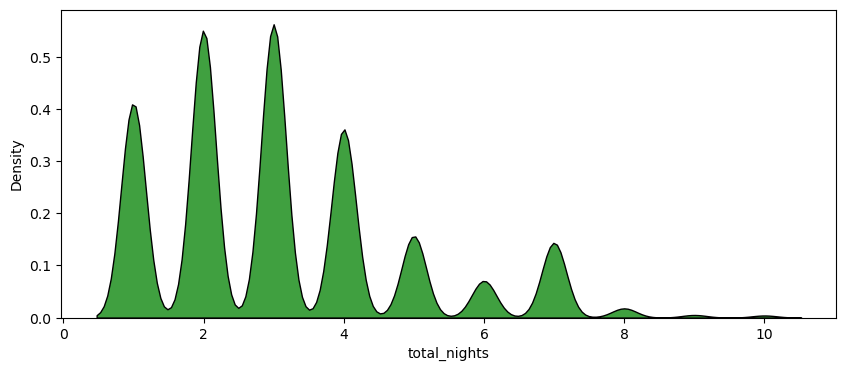

In [29]:
for num in concat.select_dtypes(include=["int", "float"]).columns:
    plt.subplots(1, figsize=(10, 4))
    sns.kdeplot(concat[num], color="green", multiple="stack")
    plt.show()

**Выводы**

По итогам предобработки данных обнаржены и устранены не унифицированные значения категориальных переменных и другие аномалии и артефакты. Обнаружено много дубликатов, которые решено было оставить как есть.

В результате разведочного анализа данных можно сделать следующие выводы:
- дисбаланс классов на лицо, больше подтверждений брони, чем отмен;
- наиболее популярный месяц для бронивания - май;
- чаще всего клиенты прибывают в отель из Португалии;
- больше всего клиенты предпочитают питание - только завтраки и самые дорогие номера;
- самый популярный тип клиента Transient - индивидуальные заезды;
- lead_time (количество дней между датой бронирования и датой прибытия) с длинным хвостом, в данных есть выбросы, однако удалять эти данные пока не будем;
- начало и конец года менее популярны для путешествий, поэтому бронирований у отеля в эти недели намного меньше;
- первые и последние числа месяца также менее популярны для бронирования;
- большинство захватывают от 1 до 3 будних и от 0 до 2 выходных дней;
- как правило, бронирование включает двух взрослых постояльцев, стоит подметить, что отели могут не принимают одиноких мужчин, но принять женщин;
- взрослые постояльцы, как правило, бронируют отель без детей в возрасте от 3 до 14 лет и младенцев;
- большинство в отеле впервые, что логично, мало кто регулярно отдыхает в одном и том же отеле;
- клиенты, как правило, не отменяют брони, но и есть те, кто отменяют, их доля значительно меньше;
- клиенты не вносят изменения в условия брони, доля клиентов запросивщих изменения изначальных условий бронирования значительно ниже;
- большая часть клиентов не попадают в лист ожидания, но есть и те, кто по 100-150 дней ожидают свое бронирование, что очень странно;
- как правило парковочное место не запрашивается;
- количество специальных отметок, в основном, варьируется от 0 до 2;
- постояльцы, как правило, берут номера общим сроком до 5 дней.

[В начало](#intro)

## Формулировка ML-задачи на основе бизнес-задачи

Для удобства расчета прибыли сделаем словари со стоимостью самого номера, обслуживания и сезонного коэффициента.

In [30]:
room_prices = {
    "A": [1000, 400],
    "B": [800, 350],
    "C": [600, 350],
    "D": [550, 150],
    "E": [500, 150],
    "F": [450, 150],
    "G": [350, 150]
                    }

season_coeff = {
    "December": 1.0,
    "January": 1.0,
    "February": 1.0,
    "March": 1.2,
    "April": 1.2,
    "May": 1.2,
    "June": 1.4,
    "July": 1.4,
    "August": 1.4,
    "September": 1.2,
    "October": 1.2,
    "November": 1.2
}

Напишем функцию расчета прибыли без учета системы депозитов, все клиенты могут бронировать номера без предоплаты.

In [31]:
def set_profit(row):
    if row["is_canceled"] == 0:
        return ((room_prices[row["reserved_room_type"]][0]  
                * season_coeff[row["arrival_date_month"]] 
                * row["total_nights"])
                - (room_prices[row["reserved_room_type"]][1] 
                * (1 + row["total_nights"] // 2)))

    else:
        return ((room_prices[row["reserved_room_type"]][0] 
                * season_coeff[row["arrival_date_month"]])
                + room_prices[row["reserved_room_type"]][1]) *-1

In [32]:
profit_before = test.apply(set_profit, axis=1)
print("Прибыль на тестовой выборке до внедрения ML, руб.:", profit_before.sum())
print("Убыток на тестовой выборке до внедрения ML, руб.:", profit_before[profit_before<0].sum())

Прибыль на тестовой выборке до внедрения ML, руб.: 32510590.0
Убыток на тестовой выборке до внедрения ML, руб.: -18000470.0


**Выводы:**

Если внедрить возможность бронирования без предоплаты для всех, отель потреяет значительные суммы прибыль, поэтому нужна система депозитов.

[В начало](#intro)

## Разработка модели ML

Перед началом разработки модели укрупним категоризацию столбца со странами. 

In [33]:
country_cat = [] # создадим пустой список

for index, row in concat["country"].value_counts().reset_index().iterrows(): # посчитает количества броней по странам
    if row["count"] > 1000: # если количество брони > 1000
        country_cat.append(row["country"]) # добавим эту страну в наш список 
        
for data in data_list: # для обучающего и тестового набора
    for index, row in data.iterrows():
        if row["country"] in country_cat: # если страна есть в нашем списке, ничего не меняем
            data.loc[index, "country_cat"] = row["country"]
        else:
            data.loc[index, "country_cat"] = "other" # для остальных пишем other

Удалим прежние столбцы со странами.

In [34]:
train = train.drop("country", axis=1)
test = test.drop("country", axis=1)

Чтобы не портить наши выборки спокируем их в новые переменные, они нам еще пригодятся.

In [35]:
train_data = train.copy()
test_data = test.copy()

Соберем названия количественных и категориальных переменных в листы.

In [36]:
numeric = train_data.select_dtypes(include=["int","float"]).columns
non_numeric = train_data.select_dtypes(include=["object"]).columns

Для некоторых моделей будем исполовать порядковое кодирование категориальных переменных в количественные.

In [37]:
encoder = OrdinalEncoder()
encoder.fit(train_data[non_numeric])

OrdinalEncoder()

In [38]:
train_data[non_numeric] = pd.DataFrame(encoder.transform(train_data[non_numeric]), columns = train_data[non_numeric].columns)

Разделим признаки и целевой признак.

In [39]:
features_train = train_data.drop(["is_canceled"], axis=1)
target_train = train_data["is_canceled"]

Масштабируем количественные переменные.

In [40]:
scaler = StandardScaler()
scaler.fit(train_data[numeric[1:]])

features_train[numeric[1:]] = pd.DataFrame(scaler.transform(features_train[numeric[1:]]), columns = features_train[numeric[1:]].columns)

Разобьем обучающую выборку на обучающую и валидационную в соотношении 75:25.

In [41]:
features_train, features_valid, target_train, target_valid = train_test_split(features_train, target_train, test_size=0.25, random_state=12345)

In [42]:
print(features_train.shape)
print(features_valid.shape)
print(target_train.shape)
print(target_valid.shape)

(48797, 22)
(16266, 22)
(48797,)
(16266,)


Расчет показателей качества модели нам придется совершать часто, напишем отдельную функцию для этого.

In [43]:
def model_quality(model, features, target, prediction):
    cvs = np.mean(cross_val_score(model, features, target, cv=10))
    precision = precision_score(target, prediction)
    f1 = f1_score(target, prediction)
    roc_auc = roc_auc_score(target, prediction)
    print("Precision:", precision)
    print("F1_score:", f1)
    print("Roc_auc:", roc_auc)
    print("Cross_val_score:", cvs)

Для построение ROC-кривой тоже напишем функцию.

In [44]:
def draw_graph(model, features, target):
    probabilities_one_valid = model.predict_proba(features)[:,1]
    fpr, tpr, thresholds = roc_curve(target, probabilities_one_valid)
    plt.figure(figsize=(10,7))
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.plot(fpr, tpr)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC-кривая")
    plt.show()

Обучим дереверо решений и посмотрим на его качество. Казалось бы, что обучать модель стоило бы f1-мерой, где достигается лучшая гармоническая взаимосвязь показателей точности и полноты, но, если подумать, что нам важнее, как можно точно предсказать отменить ли бронь клиент или постараться охватить как можно больше таких клиентов? На мой взгляд, для того чтобы получить больше прибыли лучше использовать полноту в качеству метрики для обучения.

DecisionTreeClassifier(class_weight='balanced', max_depth=10,
                       random_state=12345)

Recall: 0.8293373293373293
Precision: 0.7151471643933955
F1_score: 0.7680209698558322
Roc_auc: 0.81798250482461
Cross_val_score: 0.8130470511834804


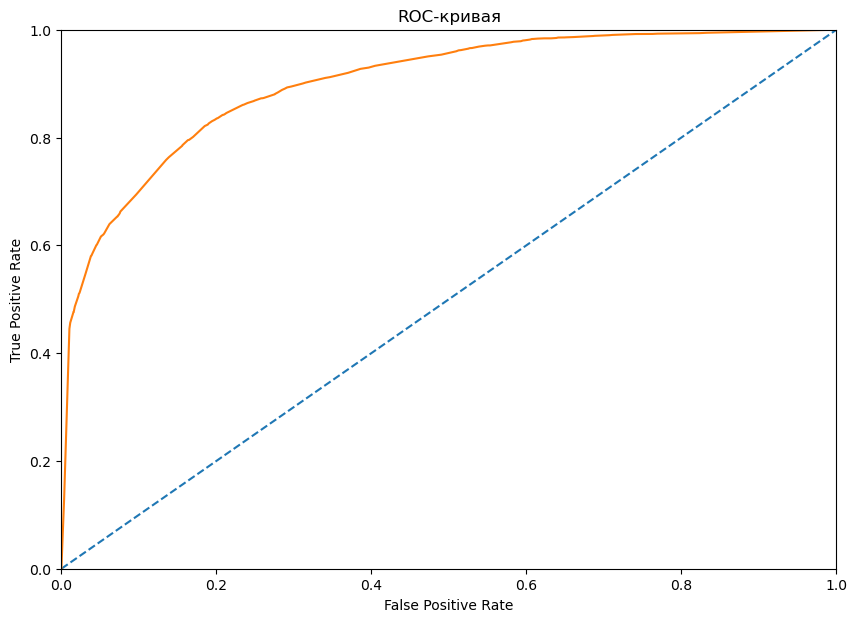

In [45]:
tree_recall = 0
best_tree = None

for depth in range(1, 11, 1):

    tree = DecisionTreeClassifier(max_depth=depth, random_state=12345, class_weight="balanced")
    tree.fit(features_train, target_train)
    predictions = tree.predict(features_valid)
    recall = recall_score(target_valid, predictions)

    if recall > tree_recall:
        tree_recall = recall
        best_tree = tree

display(best_tree)
print("Recall:", tree_recall)
model_quality(best_tree, features_valid, target_valid, predictions)
draw_graph(best_tree, features_valid, target_valid)

Тоже самое для случайного леса.

RandomForestClassifier(class_weight='balanced', max_depth=9, n_estimators=10,
                       random_state=12345)

Recall: 0.7910422910422911
Precision: 0.7851031706089582
F1_score: 0.7821509150162949
Roc_auc: 0.8271834890255944
Cross_val_score: 0.8229448701985482


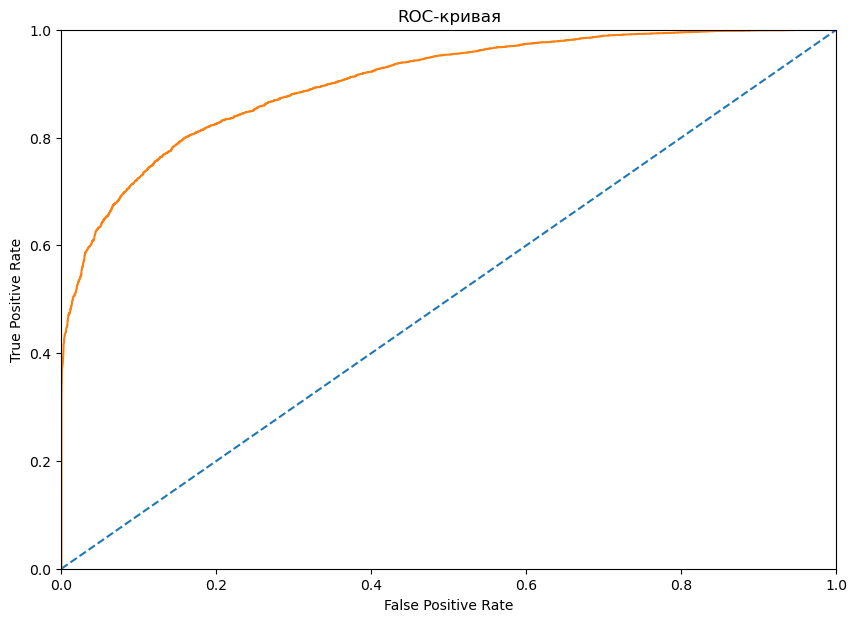

In [46]:
forest_recall = 0
best_forest = None

for est in range(10, 51, 10):
    for depth in range (1, 11, 1):
        
        forest = RandomForestClassifier(max_depth=depth, n_estimators=est, random_state=12345, class_weight="balanced")
        forest.fit(features_train, target_train)
        predictions = forest.predict(features_valid)
        recall = recall_score(target_valid, predictions)
        
        if recall > forest_recall:
            forest_recall = recall
            best_forest = forest

display(best_forest)
print("Recall:", forest_recall)
model_quality(best_forest, features_valid, target_valid, predictions)
draw_graph(best_forest, features_valid, target_valid)

Проверим, отличается ли наша модель от той, которая предсказывает просто самый частый целевой признак,

In [47]:
dummy_model = DummyClassifier(strategy="most_frequent", random_state=12345)
dummy_model.fit(features_train, target_train)
dummy_model.score(features_train, target_train)

0.6313297948644384

Качество модели довольно низкое, что подверждает то, что наши модели хорошо различают целевые признаки.

Все показатели модели хорошие, наблюдается высокая полноста и точность, кривая ROC сильно за линию диагонали, также кросвалидация показывает, что наши результаты не ошибочные. 

Что по логистической регрессии?

Предудующие датафреймы нам не подходят, поскольку на них мы применили порядкое кодирование, что не работает с логистической регрессией. Заново скопируем подгтовленный нами датафрейм в нашу переменную и проделаем все этапы по аналогии.

In [48]:
train_data = train.copy()
train_data = pd.get_dummies(train_data, drop_first=True)

In [49]:
features_train = train_data.drop(["is_canceled"], axis=1)
target_train = train_data["is_canceled"]

In [50]:
features_train[numeric[1:]] = pd.DataFrame(scaler.transform(features_train[numeric[1:]]), columns = features_train[numeric[1:]].columns)

In [51]:
features_train, features_valid, target_train, target_valid = train_test_split(features_train, target_train, test_size=0.25, random_state=12345)

Обучим логистическую регрессию, рассчитаем показатели качества модели и построим ROC-кривую.

Recall: 0.7537462537462537
Precision: 0.6895658796648896
F1_score: 0.7202290987192745
Roc_auc: 0.7775553880817039
Cross_val_score: 0.7863649318730432


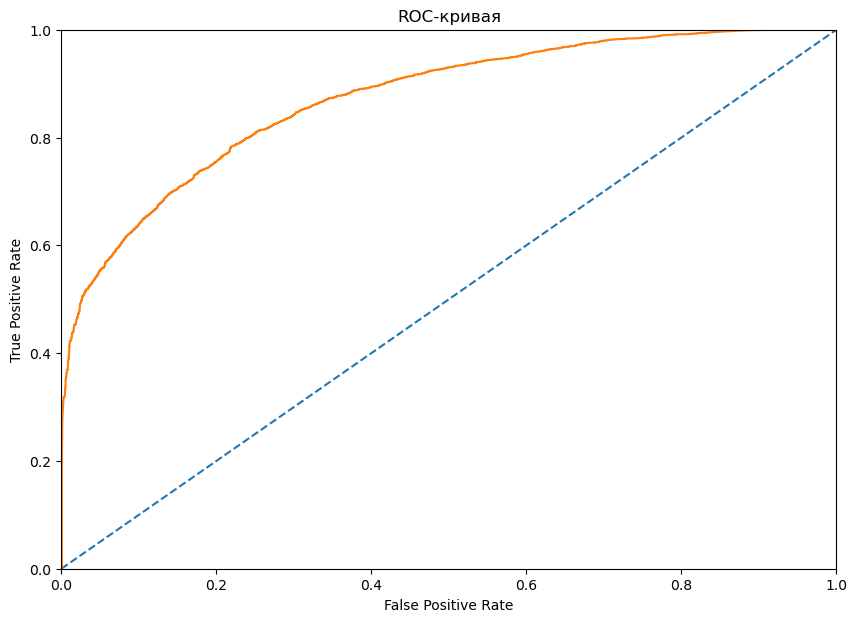

In [52]:
logistic = LogisticRegression(random_state=12345, class_weight="balanced", solver="liblinear")
logistic.fit(features_train, target_train)
predictions = logistic.predict(features_valid)
logistic_recall = recall_score(target_valid, predictions)
print("Recall:", logistic_recall)
model_quality(logistic, features_valid, target_valid, predictions)
draw_graph(logistic, features_valid, target_valid)

С точки зрения охвата полноты лучше всего подходит дерево решений, затем случайный лес и логистическая регрессия. Посмотрим, как дела обстоят на практике.

Напишем функцию для расчета прибыли отеля после внедрения депозитной системы.

In [53]:
def set_profit(row):
    if row["is_canceled"] == 0: # если фактически клиент не отменял бронь мы получаем прибыль
        return ((room_prices[row["reserved_room_type"]][0] 
                * season_coeff[row["arrival_date_month"]] 
                * row["total_nights"]) 
                - (room_prices[row["reserved_room_type"]][1] 
                * (1 + row["total_nights"] // 2)))
    if row["predictions"] == 0 and row["is_canceled"] == 1: # если фактически была отмена брони, а наша модель это не предвидела, мы получаем убыток
        return ((room_prices[row["reserved_room_type"]][0] 
                * season_coeff[row["arrival_date_month"]]) 
                + room_prices[row["reserved_room_type"]][1]) *-1
    if row["predictions"] == 1 and row["is_canceled"] == 1: # если фактически мы получили отмену и модель это предугадала, то мы просим оставлять депозит в 80%
        return ((((room_prices[row["reserved_room_type"]][0] 
                * season_coeff[row["arrival_date_month"]]) 
                + room_prices[row["reserved_room_type"]][1]) *.8) 
                - ((room_prices[row["reserved_room_type"]][0] 
                * season_coeff[row["arrival_date_month"]]) 
                + room_prices[row["reserved_room_type"]][1]))   

Подготовим тестовую выборку для предсказания.

In [54]:
test_data[non_numeric] = pd.DataFrame(encoder.transform(test_data[non_numeric]), columns = test_data[non_numeric].columns)

In [55]:
features_test = test_data.drop(["is_canceled"], axis=1)
target_test = test_data["is_canceled"]

In [56]:
features_test[numeric[1:]] = pd.DataFrame(scaler.transform(features_test[numeric[1:]]), columns = features_test[numeric[1:]].columns)

Проверим уже обученные лучшие модели на тестовой выборке.

In [57]:
predictions = best_forest.predict(features_test)

Расчитаем на тестовой выборке показатели качества модели, построим ROC-кривую и рассчитаем прибыль отеля.

Recall: 0.6427547770700637
Precision: 0.7144880077882998
F1_score: 0.6767257638626932
Roc_auc: 0.7398427375720839
Cross_val_score: 0.6347233461320456


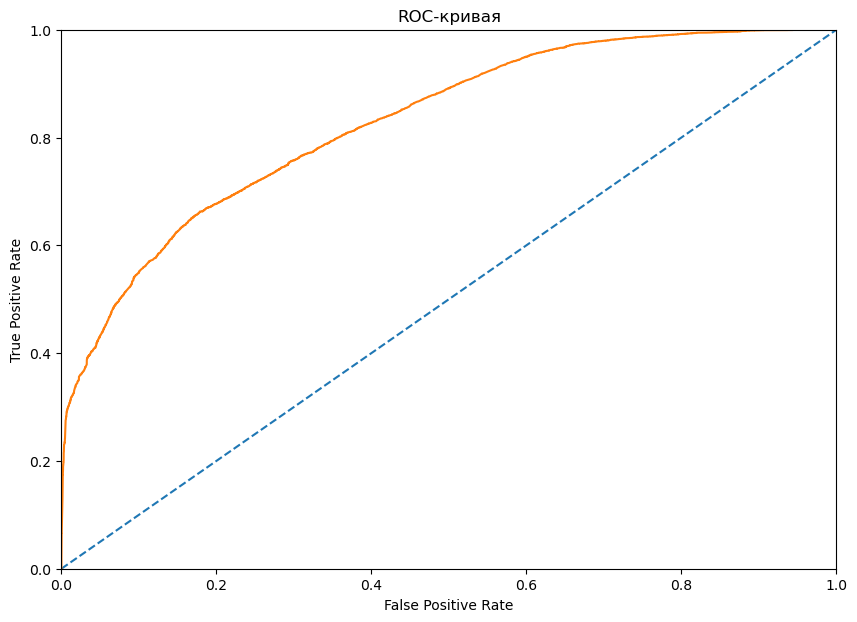

Прибыль на тестовой выборке после внедрения ML, руб.: 41984326.0
Убыток на тестовой выборке после внедрения ML, руб.: -8526734.0
Прирост прибыли после внедрения модели случайного леса, руб.: 9473736.0


In [58]:
forest_recall = recall_score(target_test, predictions)
print("Recall:", forest_recall)
model_quality(best_forest, features_test, target_test, predictions)
draw_graph(best_forest, features_test, target_test)
test["predictions"] = pd.Series(predictions)
profit_forest = test.apply(set_profit, axis=1)
print("Прибыль на тестовой выборке после внедрения ML, руб.:", profit_forest.sum())
print("Убыток на тестовой выборке после внедрения ML, руб.:", profit_forest[profit_forest<0].sum())
print("Прирост прибыли после внедрения модели случайного леса, руб.:",  profit_forest.sum() - profit_before.sum())

Посмотрим как поведет себя дерево решений с тестовой выборкой.

Recall: 0.6615445859872612
Precision: 0.6473704713673549
F1_score: 0.6543807836188227
Roc_auc: 0.7163811490821914
Cross_val_score: 0.6226669591540424


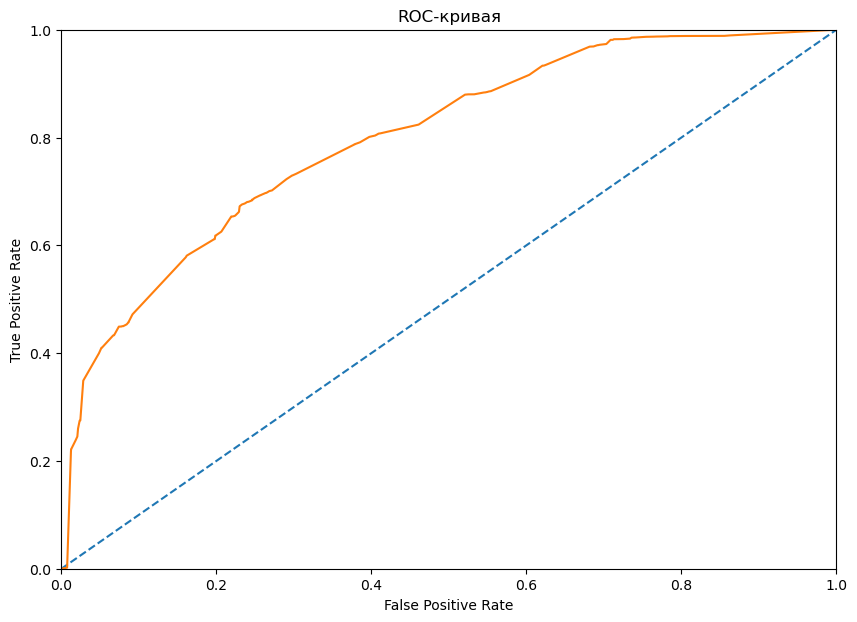

Прибыль на тестовой выборке после внедрения ML, руб.: 42185118.0
Убыток на тестовой выборке после внедрения ML, руб.: -8325942.0
Прирост прибыли после внедрения модели дерево решений, руб.: 9674528.0


In [59]:
predictions = best_tree.predict(features_test)
tree_recall = recall_score(target_test, predictions)
print("Recall:", tree_recall)
model_quality(best_tree, features_test, target_test, predictions)
draw_graph(best_tree, features_test, target_test)
test["predictions"] = pd.Series(predictions)
profit_tree = test.apply(set_profit, axis=1)
print("Прибыль на тестовой выборке после внедрения ML, руб.:", profit_tree.sum())
print("Убыток на тестовой выборке после внедрения ML, руб.:", profit_tree[profit_tree<0].sum())
print("Прирост прибыли после внедрения модели дерево решений, руб.:",  profit_tree.sum() - profit_before.sum())

Проверим логистическую регрессию на тестовой выборке.

In [60]:
test_data = test.copy()

In [61]:
train_data = pd.get_dummies(train_data, drop_first=True)
test_data = pd.get_dummies(test_data, drop_first=True)

Поскольку мы делаем прямое кодирование категориальных переменных, то может быть так, что количество столбцов в тестовой выборке будет меньше, чем на обучающей выборке, что может привести к ошибке, исправим это.

In [62]:
for col in train_data.columns: # все столбцы, которых нет в тестовой выборке заполним нулями.
    if col not in test_data.columns:
        test_data[col] = 0
        
test_data = test_data[train_data.columns]

print(train_data.shape)
print(test_data.shape)

(65063, 56)
(32343, 56)


In [63]:
features_test = test_data.drop(["is_canceled"], axis=1)
target_test = test_data["is_canceled"]

In [64]:
features_test[numeric[1:]] = pd.DataFrame(scaler.transform(features_test[numeric[1:]]), columns = features_test[numeric[1:]].columns)

Recall: 0.6441082802547771
Precision: 0.6950171821305842
F1_score: 0.668595041322314
Roc_auc: 0.7323306401526628
Cross_val_score: 0.6581309483186277


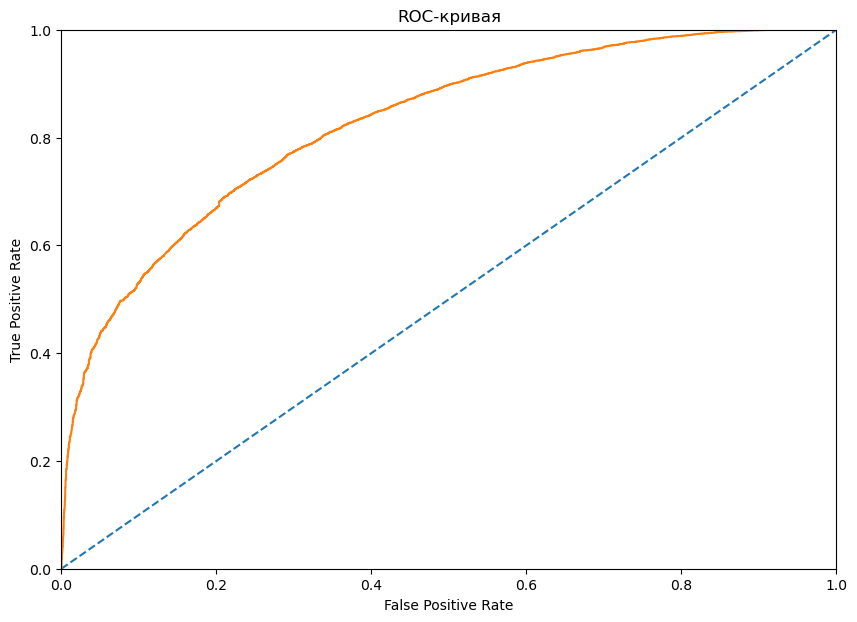

Прибыль на тестовой выборке после внедрения ML, руб.: 42033990.0
Убыток на тестовой выборке после внедрения ML, руб.: -8477070.0
Прирост прибыли после внедрения модели дерево решений, руб.: 9523400.0


In [65]:
predictions = logistic.predict(features_test)
logistic_recall = recall_score(target_test, predictions)

print("Recall:", logistic_recall)

model_quality(logistic, features_test, target_test, predictions)
draw_graph(logistic, features_test, target_test)

test["predictions"] = pd.Series(predictions)
profit_logistic = test.apply(set_profit, axis=1)

print("Прибыль на тестовой выборке после внедрения ML, руб.:", profit_logistic.sum())
print("Убыток на тестовой выборке после внедрения ML, руб.:", profit_logistic[profit_logistic<0].sum())
print("Прирост прибыли после внедрения модели дерево решений, руб.:",  profit_logistic.sum() - profit_before.sum())

Посмотрим на распределение точности, полноты, прибыли и убытка в зависимости от порога на примере логистической регрессии.

In [66]:
probabilities_valid = logistic.predict_proba(features_test)
probabilities_one_valid = probabilities_valid[:, 1]

In [67]:
for threshold in np.arange(0, 1, 0.03):
    predictions = (probabilities_one_valid > threshold)*1
    precision = precision_score(target_test, predictions)
    recall = recall_score(target_test, predictions)
    test["predictions"] = pd.Series(predictions)
    profit_logistic = test.apply(set_profit, axis=1)
    print(f"| Порог = {threshold:.2f} | Точность = {precision:.3f} | Полнота = {recall:.3f} | Прибыль = {profit_logistic.sum()} | Убыток = {profit_logistic[profit_logistic<0].sum()} |")

| Порог = 0.00 | Точность = 0.388 | Полнота = 1.000 | Прибыль = 46910966.0 | Убыток = -3600094.0 |
| Порог = 0.03 | Точность = 0.417 | Полнота = 0.998 | Прибыль = 46884966.0 | Убыток = -3626094.0 |
| Порог = 0.06 | Точность = 0.431 | Полнота = 0.994 | Прибыль = 46825102.0 | Убыток = -3685958.0 |
| Порог = 0.09 | Точность = 0.446 | Полнота = 0.985 | Прибыль = 46704214.0 | Убыток = -3806846.0 |
| Порог = 0.12 | Точность = 0.463 | Полнота = 0.972 | Прибыль = 46534182.0 | Убыток = -3976878.0 |
| Порог = 0.15 | Точность = 0.480 | Полнота = 0.956 | Прибыль = 46319078.0 | Убыток = -4191982.0 |
| Порог = 0.18 | Точность = 0.499 | Полнота = 0.938 | Прибыль = 46074270.0 | Убыток = -4436790.0 |
| Порог = 0.21 | Точность = 0.517 | Полнота = 0.916 | Прибыль = 45774270.0 | Убыток = -4736790.0 |
| Порог = 0.24 | Точность = 0.535 | Полнота = 0.894 | Прибыль = 45473118.0 | Убыток = -5037942.0 |
| Порог = 0.27 | Точность = 0.553 | Полнота = 0.870 | Прибыль = 45131342.0 | Убыток = -5379718.0 |
| Порог = 

Для привлечения клиентов лучше всего внедрить умную систему депозитов на основе ML, которая будет предсказывать кто может потенциально отменить бронь и у таких клиентов запрашивать депозит.

**Выводы:**

Все модели показали значительный прирост прибыли, за год модели могут окупиться десятки раз, учитывая расходы в размере 400 тыс. на разработку самой модели.

Модели обучены и готовы, какую выбрать модель? Зависит от цели:
- максимизация прибыли - дерево решений;
- высокая точность - случайный лес;
- высокая скорость - логистическая регрессия.

Однако, можно комбинировать точность, полноту со скоросью: для этого можно задать нужную точность, полноту используя пороги и выбрать самую быструю модель(в нашем случае логистическую регрессию), быстрота имеет значение, особенно, если нужно в режиме онлайн нужно предсказать отмену брони клиентом.

[В начало](#intro)

## Портрет «ненадёжного» клиента

Рассмотрим некоторые зависимости и составим портрет клиента, который потенциально может отменить бронь.

Объединим датафреймы, чтобы на основе общих данных сделать более точне выводы.

In [68]:
data = pd.concat([train]+[test])
data = data.drop("predictions", axis=1)

Посмотрим на зависимости количественных данных с отменой брони.

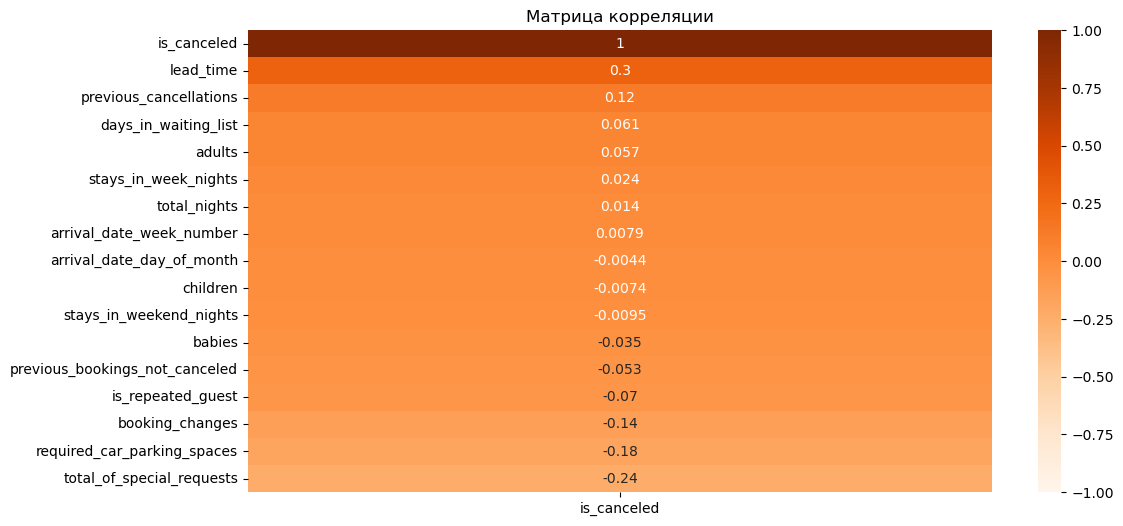

In [69]:
corr_matrix = data.select_dtypes(include=["int", "float"]).corr()[["is_canceled"]].sort_values("is_canceled",ascending=False)

plt.figure(figsize = (12, 6))
sns.heatmap(corr_matrix,
            vmin=-1, 
            vmax=1,
            annot=True,
            cmap="Oranges")
plt.title("Матрица корреляции")
plt.show()

In [70]:
data

,is_canceled,lead_time,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,country_cat
0,0,7.0,July,27,1,0,1,1.0,0.0,0.0,BB,Direct,0,0,0,A,0,0,Transient,0,0,1,GBR
1,0,14.0,July,27,1,0,2,2.0,0.0,0.0,BB,TA/TO,0,0,0,A,0,0,Transient,0,1,2,GBR
2,0,0.0,July,27,1,0,2,2.0,0.0,0.0,BB,Direct,0,0,0,C,0,0,Transient,0,0,2,PRT
3,0,9.0,July,27,1,0,2,2.0,0.0,0.0,FB,Direct,0,0,0,C,0,0,Transient,0,1,2,PRT
4,1,85.0,July,27,1,0,3,2.0,0.0,0.0,BB,TA/TO,0,0,0,A,0,0,Transient,0,1,3,PRT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32338,0,164.0,August,35,31,2,4,2.0,0.0,0.0,BB,TA/TO,0,0,0,A,0,0,Transient,0,0,6,DEU
32339,0,21.0,August,35,30,2,5,2.0,0.0,0.0,BB,TA/TO,0,0,0,A,0,0,Transient,0,2,7,BEL
32340,0,23.0,August,35,30,2,5,2.0,0.0,0.0,BB,TA/TO,0,0,0,A,0,0,Transient,0,0,7,BEL
32341,0,34.0,August,35,31,2,5,2.0,0.0,0.0,BB,TA/TO,0,0,0,D,0,0,Transient,0,4,7,DEU


Топ-3 зависимостей:
- наибольшая зависимость между "lead_time" (количество дней между датой бронирования и датой прибытия) и отменой брони, то есть чем заранее бронируется номер, тем выше вероятность отмены, планы могут изменится у любого человека.
- если клиент раньше отменял брони, то вероятность отмены в очереденой раз повышается.
- чем меньше специальных пометок, тем выше вероятность отмены, однако про какие специальные пометки не говорится.

На мой взгляд также стоит обращать внимание на days_in_waiting_list(сколько дней заказ ожидал подтверждения), полагаю, чем больше заказ ожидает подтвеждения тем выше вероятность отмены.

Посмотрим также завимости категориальных данных с отменой брони.

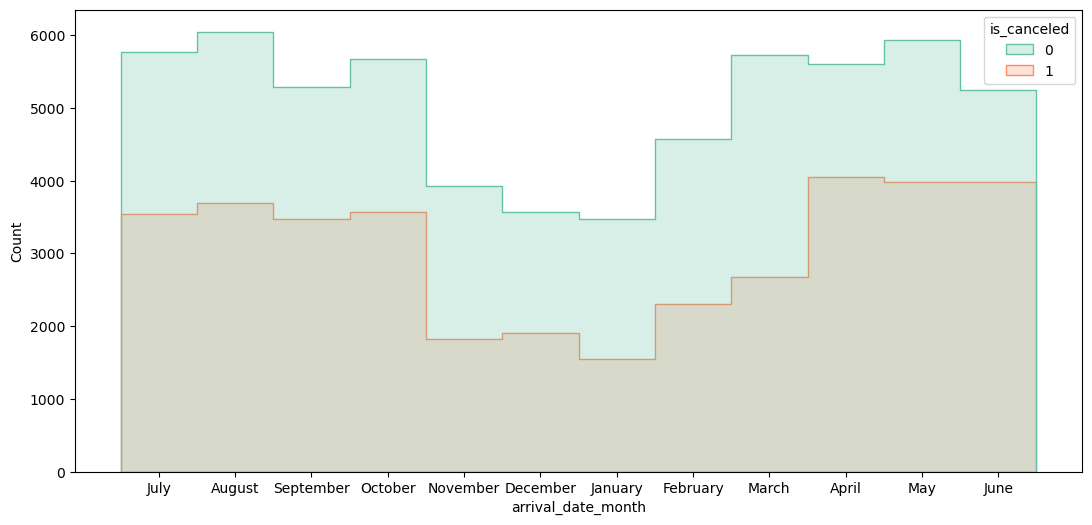

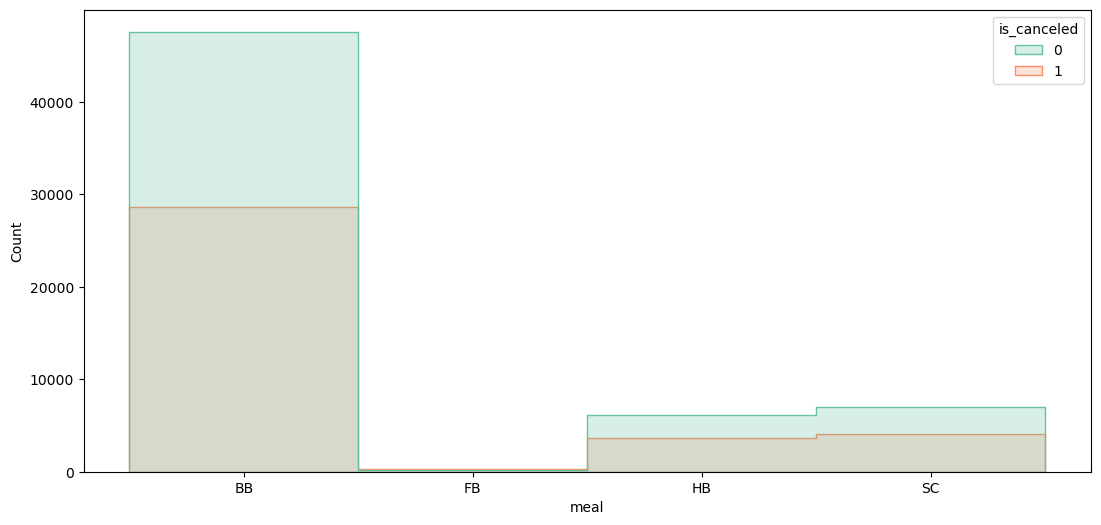

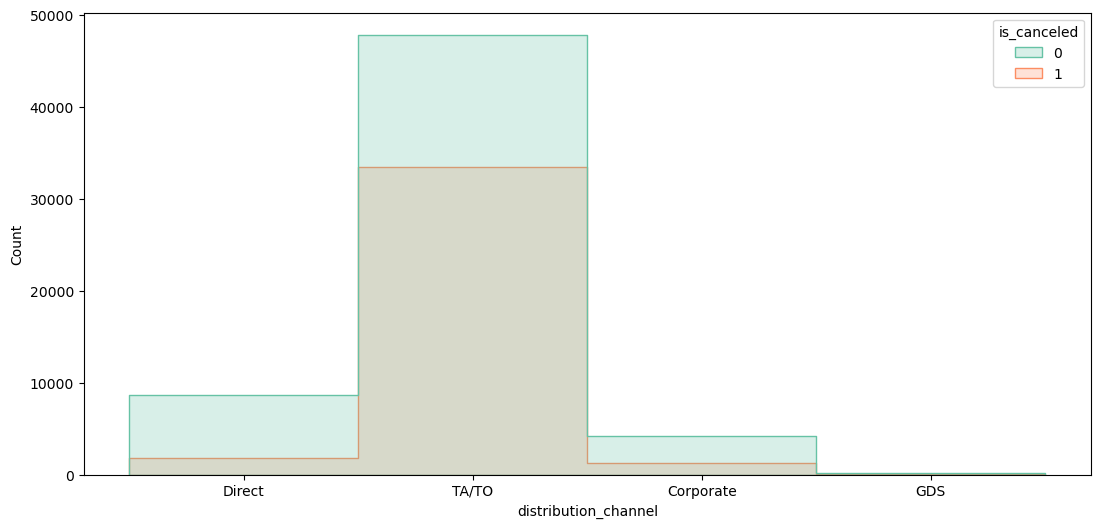

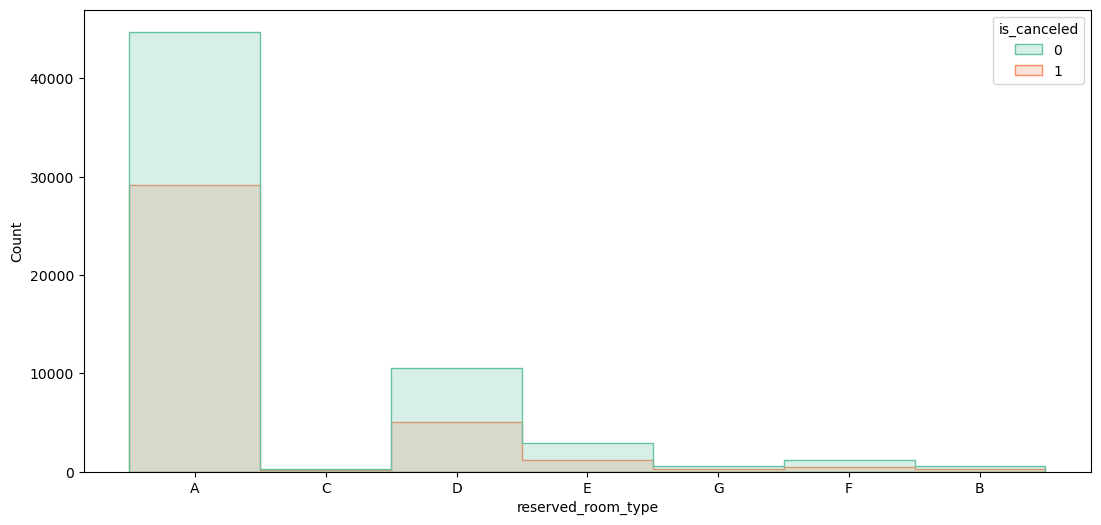

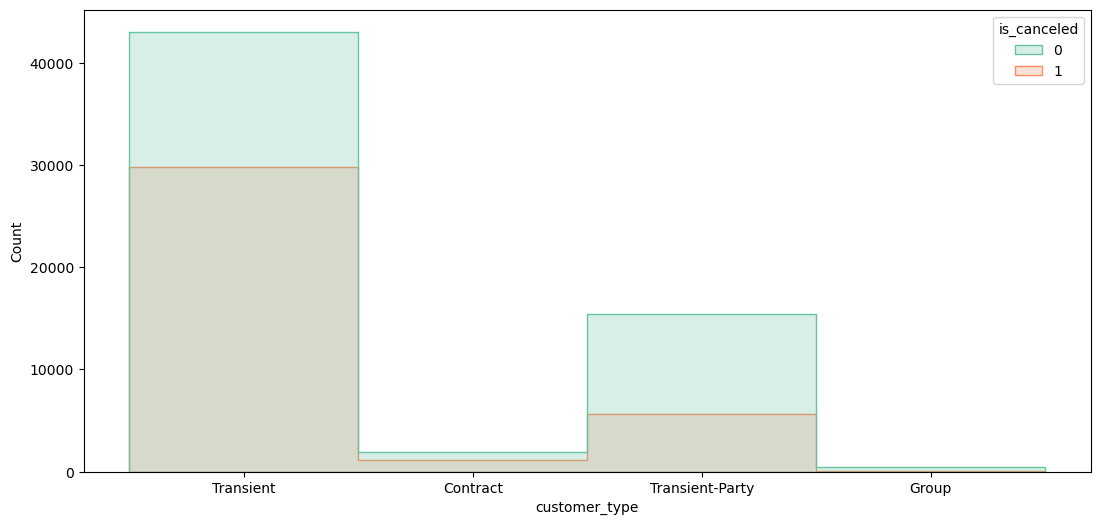

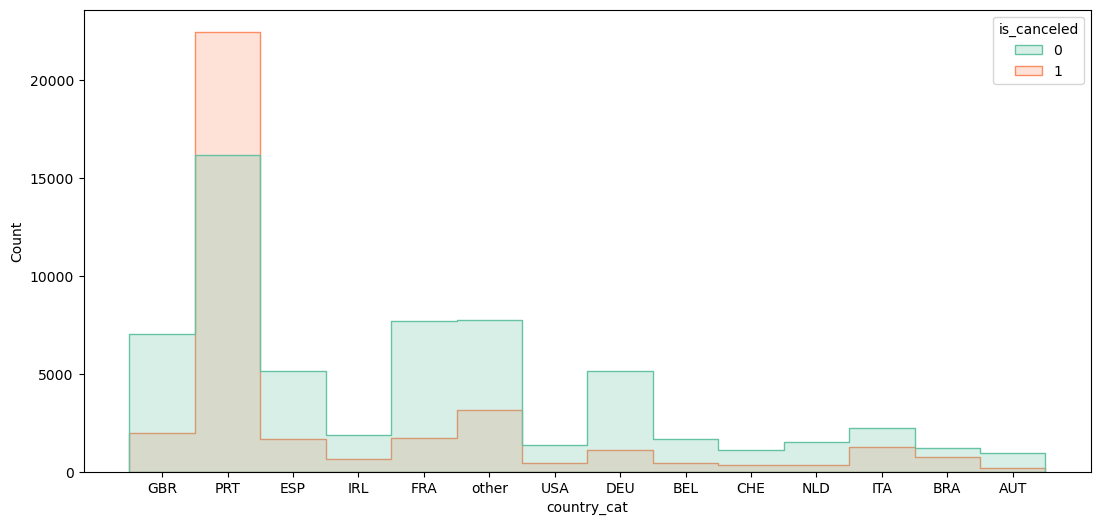

In [71]:
for col in data.select_dtypes(include="object").columns:
    plt.subplots(1, figsize=(13, 6))
    sns.histplot(data=data, 
                 x=col, 
                 hue="is_canceled", 
                 bins=len(data[col].unique()), 
                 palette="Set2", 
                 element="step")
    plt.show()

**Выводы:**

Месяц бронирования, тип питания,  не влияют на отмену брони, число подверждений и отмен равнозначно подают и растут по месяцам и типам питания. 

На отмену бронирования влияют такие параметры как:
- количество дней между датой бронирования и датой прибытия, с ростом которого растет вероятность отмены брони;
- наличие предыдующих отмен брони повышает вероятность отмены в очереденой раз;
- отсутствие специальных пометок, повышает вероятность отмены;
- длительный срок ожидания заказа клиента;
- канал дистрибуции равный TA/TO;
- премиальность номера;
- тип-заказчика равный Transient;
- страна прибытия, если это Португалия.

[В начало](#intro)

## Общие выводы

**Предобработка данных**

По итогам предобработки данных обнаржены и устранены не унифицированные значения категориальных переменных и другие аномалии и артефакты, ненужные данные. Обнаружено много дубликатов, которые решено было оставить как есть.

**Исследовательский анализ данных (EDA):**

- дисбаланс классов на лицо, больше подтверждений брони, чем отмен;
- наиболее популярный месяц для бронивания - май;
- чаще всего клиенты прибывают в отель из Португалии;
- больше всего клиенты предпочитают тип питания - только завтраки и самые дорогие номера;
- самый популярный тип клиента Transient - индивидуальные заезды;
- lead_time (количество дней между датой бронирования и датой прибытия) с длинным хвостом, в данных есть выбросы, однако удалять эти данные пока не будем;
- начало и конец года менее популярны для путешествий, поэтому бронирований у отеля в эти недели намного меньше;
- первые и последние числа месяца также менее популярны для бронирования;
- большинство захватывают от 1 до 3 будних и от 0 до 2 выходных дней с общим сроком до 5 дней;
- как правило, бронирование включает двух взрослых постояльцев, стоит подметить, что отели могут не принимают одиноких мужчин, но принять женщин;
- взрослые постояльцы, как правило, бронируют отель без детей в возрасте от 3 до 14 лет и младенцев;
- большинство в отеле впервые, что логично, мало кто регулярно отдыхает в одном и том же отеле;
- клиенты, как правило, не отменяют брони, но и есть те, кто отменяют, их доля значительно меньше;
- клиенты не вносят изменения в условия брони, доля клиентов запросивщих изменения изначальных условий бронирования значительно ниже;
- большая часть клиентов не попадают в лист ожидания, но есть и те, кто по 100-150 дней ожидают свое бронирование, что очень странно;
- как правило парковочное место не запрашивается;
- количество специальных отметок, в основном, варьируется от 0 до 2.

**Результаты моделей**

Все модели показали достойные результаты, во всех случаях затраты на построение модели окупились. Самую высокую прибыль дала модель на основе дерева решений, поскольку прибыль наша целевая метрика мы предлагаем использовать именно эту модель, она не самая точная и не самая быстрая. Однако, можно комбинировать точность, полноту со скоросью: для этого можно задать нужную точность, полноту используя пороги и выбрать самую быструю модель(в нашем случае логистическую регрессию), быстрота имеет значение, особенно, если нужно в режиме онлайн нужно предсказать отмену брони клиентом.

**Портрет «ненадёжного» клиента**

Ненадежным считается клиент, который:
- выбрал дату заселений сильное заранее, планы могут изменится у любого человека и вероятность отмены брони от этого только растет;
- если клиент раньше отменял бронь, то вероятность отмены в очереденой раз повышается;
- чем меньше специальных пометок, тем выше вероятность отмены;
- длительный срок ожидания заказа клиента также может стать причиной отмены;
- имеет канал дистрибуции TA/TO;
- выбирает самый премиальный номер;
- бронирует по собственной инициативе с оплатой из собственного кармана;
- прибывает из Португалии.

[В начало](#intro)